In [1]:
from jax import numpy as jnp
from jax import jacfwd, jacrev, jit, vmap, lax, make_jaxpr
from jax import random as jr
from jax import tree_util as jtu
import jax
from functools import partial
import tensorflow

import gaussfiltax.utils as utils
import gaussfiltax.containers as containers
from dynamax.nonlinear_gaussian_ssm.models import ParamsNLGSSM, NonlinearGaussianSSM
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
import time
import gaussfiltax.inference as gf
import gaussfiltax.particlefilt as pf
from gaussfiltax.gaussfilt import SSM

import matplotlib.pyplot as plt

## Models and simulations

In [2]:
# Parameters
state_dim = 1
emission_dim = 1
seq_length = 100
mu0 = jnp.zeros(state_dim)
Sigma0 = 1.0 * jnp.eye(state_dim)
Q = 1.0 * jnp.eye(state_dim)
R = 10.0 * jnp.eye(emission_dim)

# Nonlinearities
f1 = lambda x, u: (1-u) * x / 2.  + u * jnp.sin(10 * x)
g1 = lambda x, u: .8 * x # 0.01 * jnp.array([jnp.dot(x, x)])

f2 = lambda x: 0.8 * x
def g2(x):
    return 2 * x

# Lorenz 63
def lorentz_63(x, sigma=10, rho=28, beta=2.667, dt=0.01):
    dx = dt * sigma * (x[1] - x[0])
    dy = dt * (x[0] * rho - x[1] - x[0] *x[2]) 
    dz = dt * (x[0] * x[1] - beta * x[2])
    return jnp.array([dx+x[0], dy+x[1], dz+x[2]])
f63 = lambda x, u: lorentz_63(x) 

# stochastic growth model
f3 = lambda x, u: x / 2. + 25. * x / (1+ jnp.power(x, 2)) * u
g3 = lambda x, u: x**2 / 20.

# Inputs
# inputs = 1. * jnp.cos(0.1 * jnp.arange(seq_length))
sm = lambda x : jnp.exp(x) / (1+jnp.exp(x))
# inputs = sm(jnp.arange(seq_length)-50) # off - on
inputs = jnp.ones(seq_length) # on - on

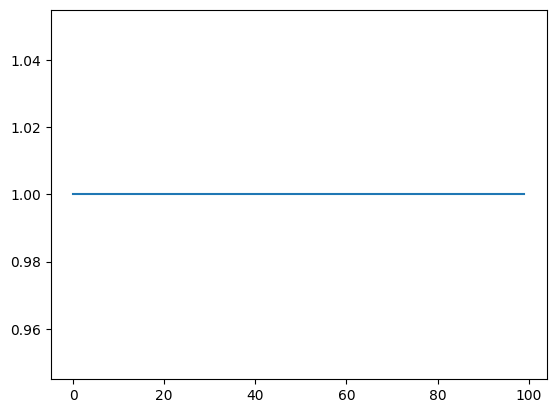

In [3]:
# plot inputs
plt.plot(inputs)
plt.show()

In [4]:
# Model definition 
model = NonlinearGaussianSSM(state_dim, emission_dim)
params = ParamsNLGSSM(
    initial_mean=mu0,
    initial_covariance=Sigma0,
    dynamics_function=f3,
    dynamics_covariance=Q,
    emission_function=g3,
    emission_covariance=R,
)

# Generate synthetic data 
key = jr.PRNGKey(0)
states, emissions = model.sample(params, key, seq_length, inputs = inputs)

## Inference

In [5]:
# GSF
M = 2
tin = time.time()
posterior_filtered_gsf = gf.gaussian_sum_filter(params, emissions, M, inputs=inputs)
tout = time.time()
print('Time taken for GSF: ', tout - tin)

# AGSF
num_components = [M, 3, 3] # has to be set correctly OW "TypeError: Cannot interpret '<function <lambda> at 0x12eae3ee0>' as a data type". Check containers._branch_from_node
tin = time.time()
posterior_filtered, aux_outputs = gf.augmented_gaussian_sum_filter(params, emissions, num_components, opt_args = (0.0, 0.1), inputs=inputs)            
tout = time.time()
print('Time taken for AGSF: ', tout - tin)

Time taken for GSF:  1.3518610000610352
Time taken for AGSF:  11.70620322227478


## Plots

### GSF

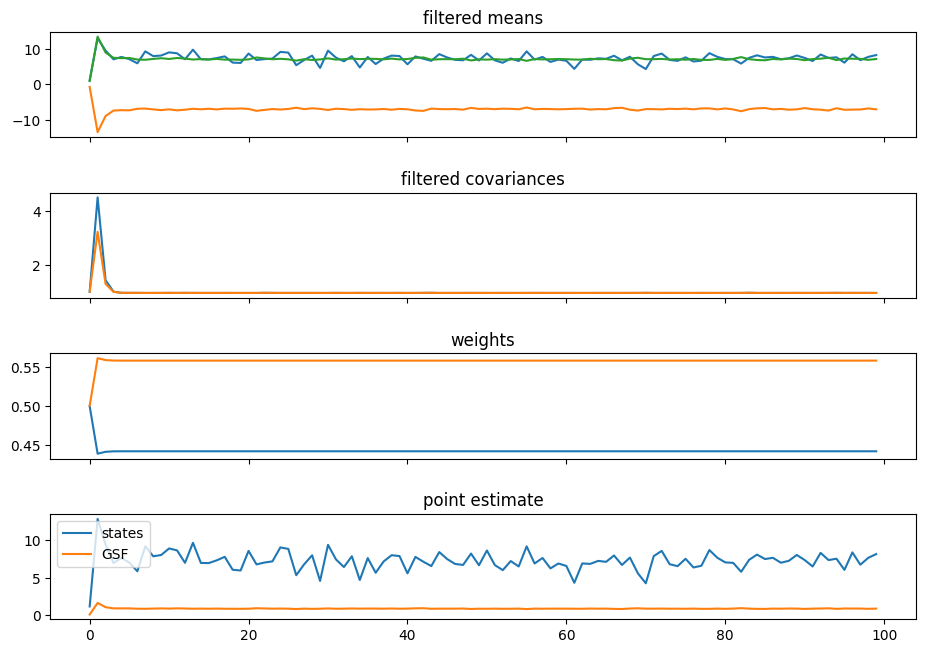

In [6]:

### GSF

num_components = num_components[0]

point_estimates = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_gsf.means, posterior_filtered_gsf.weights), axis=0)

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 7))
fig.tight_layout(pad=3.0)
axes[0].plot(states, label="xs")
leg = ["states"]
for m in range(M):
    axes[0].plot(posterior_filtered_gsf.means[m])
    leg.append("model {}".format(m))
    axes[0].set_title("filtered means")
#axes[0].legend(leg)

for m in range(M):
    axes[1].plot(posterior_filtered_gsf.covariances[m].squeeze())
    axes[1].set_title("filtered covariances")

for m in range(M):
    axes[2].plot(posterior_filtered_gsf.weights[m])
    axes[2].set_title("weights")

axes[3].plot(states, label="xs")
leg = ["states", "GSF"]
axes[3].plot(point_estimates)
axes[3].legend(leg)
axes[3].set_title("point estimate")
plt.show()

### AGSF

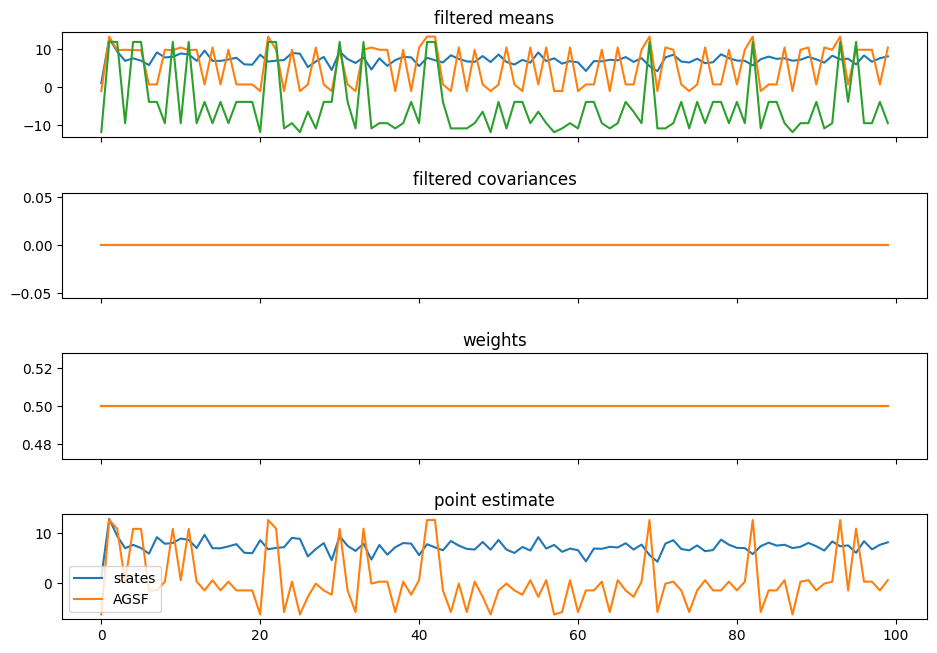

In [7]:
point_estimates = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered.means, posterior_filtered.weights), axis=0)

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 7))
fig.tight_layout(pad=3.0)
axes[0].plot(states, label="xs")
leg = ["states"]
for m in range(num_components):
    axes[0].plot(posterior_filtered.means[m])
    leg.append("model {}".format(m))
    axes[0].set_title("filtered means")

#axes[0].legend(leg)

for m in range(num_components):
    axes[1].plot(posterior_filtered.covariances[m].squeeze())
    axes[1].set_title("filtered covariances")

for m in range(num_components):
    axes[2].plot(posterior_filtered.weights[m])
    axes[2].set_title("weights")

axes[3].plot(states, label="xs")
leg = ["states", "AGSF"]
axes[3].plot(point_estimates)
axes[3].legend(leg)
axes[3].set_title("point estimate")

plt.show()

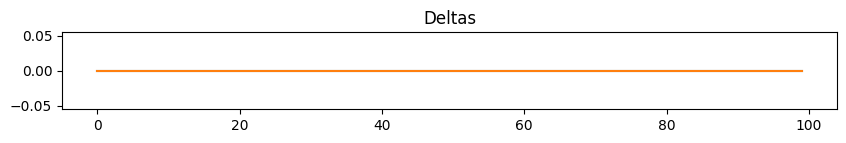

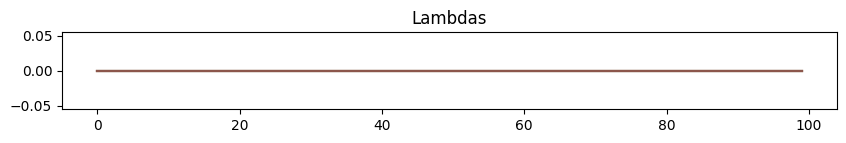

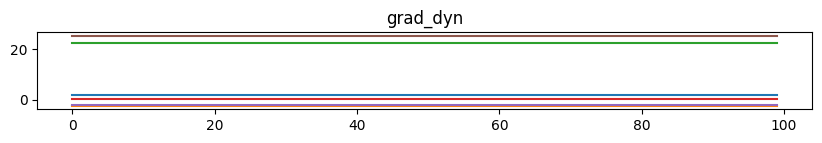

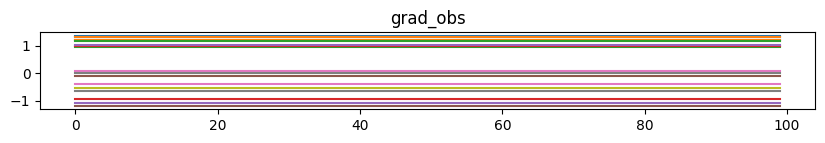

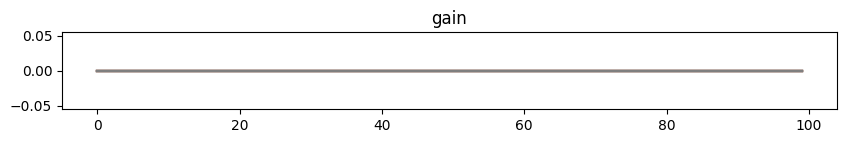

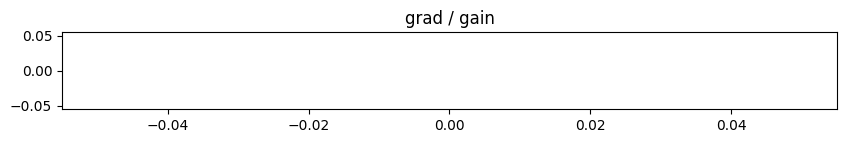

In [8]:
# plot Deltas
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["Deltas"].shape[0]):
    plt.plot(aux_outputs["Deltas"][i, :, 0])
plt.title('Deltas')
plt.show()

# plot Lambdas
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["Lambdas"].shape[0]):
    plt.plot(aux_outputs["Lambdas"][i, :, 0])
plt.title('Lambdas')
plt.show()

# plot grads_dyn
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["grads_dyn"].shape[0]):
    plt.plot(aux_outputs["grads_dyn"][i, :, 0, 0])
plt.title('grad_dyn')
plt.show()

# plot grads_obs
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["grads_obs"].shape[0]):
    plt.plot(aux_outputs["grads_obs"][i, :, 0, 0])
plt.title('grad_obs')
plt.show()

# plot gain
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["gain"].shape[0]):
    plt.plot(aux_outputs["gain"][i, :, 0, 0])
plt.title('gain')
plt.show()

# plot grads_dyn / gain
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["gain"].shape[0]):
    plt.plot(aux_outputs["grads_dyn"][i, :, 0, 0] / aux_outputs["gain"][i, :, 0, 0])
plt.title('grad / gain')
plt.show()